# Labour effects of temperature change by country (is now indicator 1.4 in 2018 edition)

1.3 Labour capacity

- Australia
- Brazil
- Canada
- China
- EU28
- France
- Germany
- India
- Spain
- Sweden
- UK/GB
- USA (Hawaii? Alaska? -> check with country author)

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

from tqdm import tqdm_notebook

import population_tools

from config import (DATA_SRC, POP_DATA_SRC, WEATHER_SRC)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.3 labour')

In [3]:

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

# NOTE that we are now using 0.5 degree data (older versions used 0.75)
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era_interim_0.5deg' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'climatology_daily_tmin_quantiles.nc'

# WISHLIST - instead of re-calculating the whole thing each year, would like to just add the newest year.
# For this would need to stablise the method though - discuss with Nick et al.
# I'm not sure it's possible to 'fully' automate since e.g. the demographic data might need to change, GWPv4 is only until 2020
# TODO: indicator -> results for year or result year -> indicator?
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2019'


# TODO - should not need these anymore with the new gridded demographics
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'


COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

## Load country data

In [4]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))

In [5]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [6]:
# COUNTRIES_NAMES = COUNTRIES.set_index('iso_a2').sovereignt
# COUNTRIES_NAMES['EU'] = 'EU28'
# COUNTRIES_RASTER = xr.open_mfdataset(str(COUNTRY_RASTER_FILES))

## Load labour capacity data

In [9]:
# labour_losses = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'labour_capacity_loss'/ '*.nc'),
#                  concat_dim='year'
#                  )

In [14]:
labour_losses = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'labour_capacity_loss_2019_edition'/ 'loss_hours_*.nc'),
                                 concat_dim='year')


In [15]:
total_loss_sectors = labour_losses.sum(dim=['latitude', 'longitude']).to_dataframe()
total_loss_sectors['total'] = total_loss_sectors.sum(axis=1)
total_loss_sectors

agriculture      industry       service         total
year                                                        
2000  8.074049e+10  7.364040e+09  6.882217e+08  8.879275e+10
2001  8.424127e+10  7.937177e+09  7.557518e+08  9.293420e+10
2002  9.029406e+10  1.013973e+10  1.233064e+09  1.016669e+11
2003  9.653087e+10  1.153609e+10  1.412183e+09  1.094791e+11
2004  8.498597e+10  9.435040e+09  7.281278e+08  9.514914e+10
2005  9.415951e+10  1.199214e+10  1.470530e+09  1.076222e+11
2006  9.289345e+10  1.222749e+10  1.220704e+09  1.063416e+11
2007  9.313471e+10  1.327146e+10  1.403654e+09  1.078098e+11
2008  7.567787e+10  9.166733e+09  7.956625e+08  8.564027e+10
2009  9.564179e+10  1.437839e+10  1.499664e+09  1.115198e+11
2010  1.133644e+11  1.914630e+10  2.162995e+09  1.346737e+11
2011  8.186464e+10  1.301116e+10  1.179597e+09  9.605540e+10
2012  8.774449e+10  1.561436e+10  1.823389e+09  1.051822e+11
2013  9.704216e+10  1.780438e+10  1.767863e+09  1.166144e+11
2014  9.704018e+10  1.834931e+10  2.227318e+09  1.176168e+11
2015  1.020923e+11  1.941102e+10  1.982010e+09  1.234853e+11
2016  1.256827e+11  2.730276e+10  3.609801e+09  1.565953e+11
2017  1.186584e+11  2.607050e+10  3.425919e+09  1.481548e+11
2018  1.064128e+11  2.395230e+10  3.209476e+09  1.335746e+11

In [17]:
labour_losses['total'] = labour_losses.agriculture + labour_losses.industry + labour_losses.service

In [11]:
# Global results for reference
total_loss_sectors = pd.read_excel(RESULTS_FOLDER / 'total loss across sectors.xlsx').set_index('year')

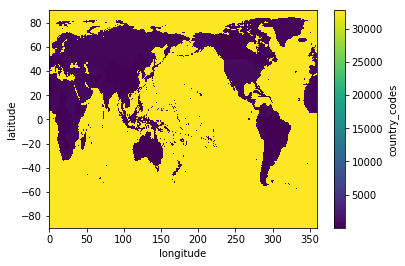

In [28]:
COUNTRIES_RASTER.country_codes.plot()

In [20]:
results = []

for _, row in tqdm_notebook(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code

    country_losses = labour_losses * country_mask
    country_losses_ts = country_losses.sum(dim=['latitude', 'longitude'], skipna=True)
    country_losses_ts['country'] = row.ISOCODE
    results.append(country_losses_ts)

results = xr.concat(results, dim='country').compute()

## Check country totals match the global total

In [29]:
from pandas.testing import assert_frame_equal
assert_frame_equal(results.sum(dim='country').to_dataframe(),total_loss_sectors)

In [24]:
# Create excel file with each sheet being one of the sectors, columns for countries, rows for years
with pd.ExcelWriter(RESULTS_FOLDER / 'labour_loss_hours_by_country.xlsx') as writer:
    results.agriculture.to_series().unstack().T.to_excel(writer, sheet_name='agriculture')
    results.industry.to_series().unstack().T.to_excel(writer, sheet_name='industry')
    results.service.to_series().unstack().T.to_excel(writer, sheet_name='service')
    results.total.to_series().unstack().T.to_excel(writer, sheet_name='total')
    
    total_loss_sectors.to_excel(writer, sheet_name='global reference')


### Plot the results as area plots for each country

In [15]:
LABOUR_LOSS_PLOTS = RESULTS_FOLDER / 'labour_loss_plots'
LABOUR_LOSS_PLOTS.mkdir(exist_ok=True)

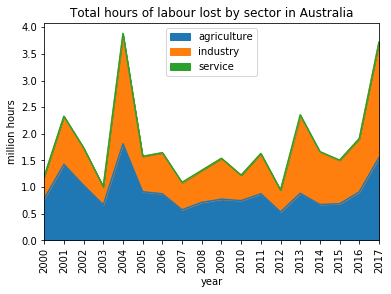

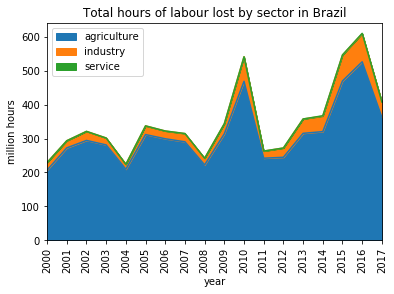

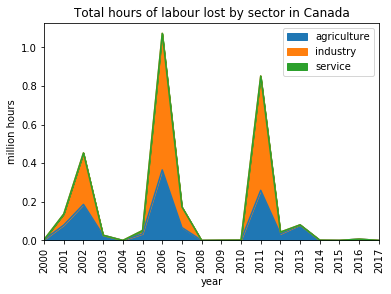

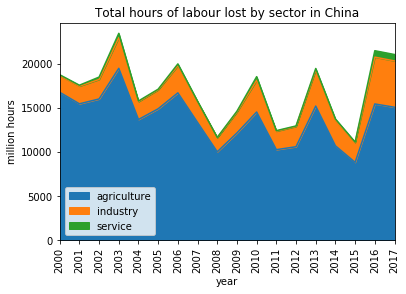

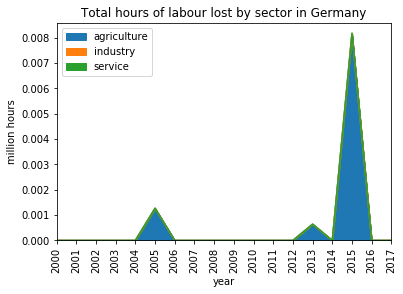

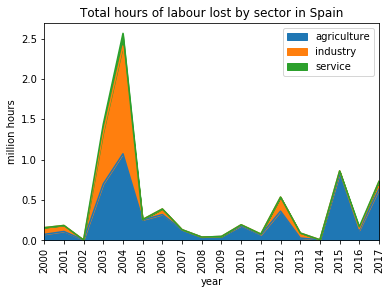

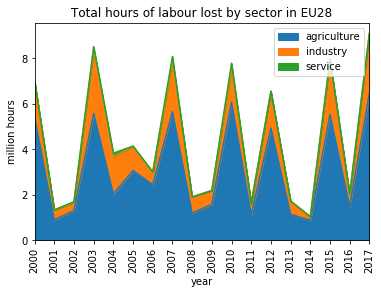

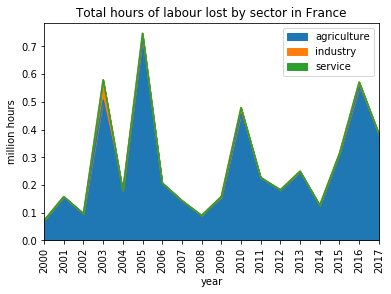

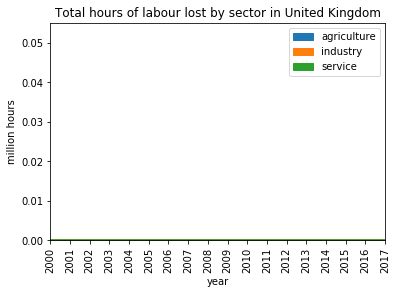

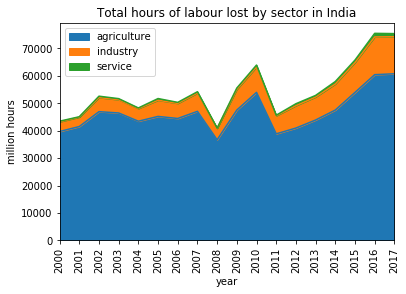

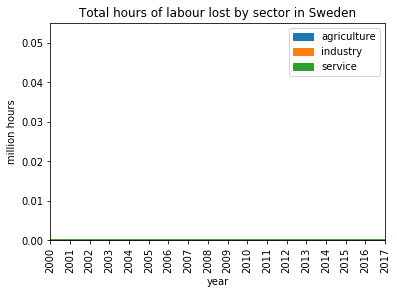

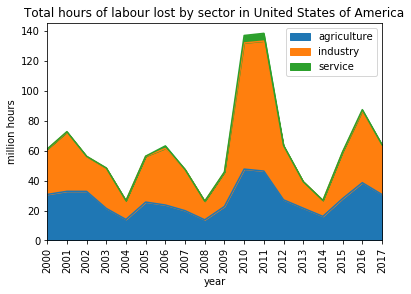

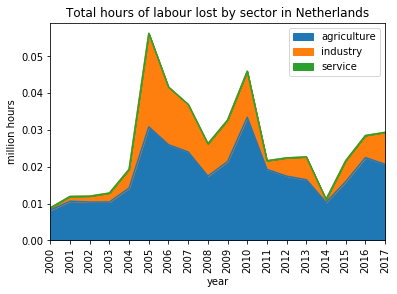

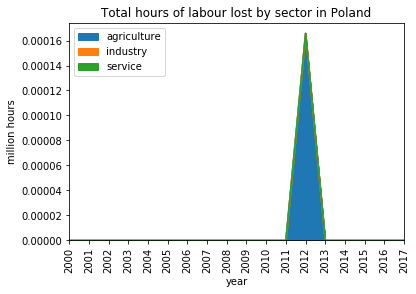

In [16]:
for h in results.country:
    h = np.asscalar(h)
    
    country_name = COUNTRIES_NAMES[h] 
    total_loss_sectors = results.sel(country=h, drop=True).to_dataframe()
    t = total_loss_sectors / 1_000_000
    ax = t[['agriculture', 'industry', 'service']].plot.area()
    ax.set_ylabel('million hours')

    plt.title(f'Total hours of labour lost by sector in {country_name}')
    plt.xlim(2000, 2017)
    plt.xticks(t.index, rotation=90)


    plt.savefig(LABOUR_LOSS_PLOTS / f'{h}_total_labour_loss_by_sector_area.png', 
                bbox_inches='tight', dpi=300)


## (Optional) Maps

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


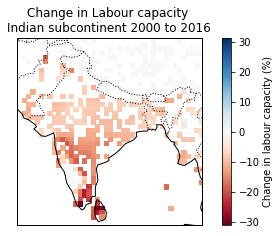

In [24]:
labour_losses

year_data = labour_losses.sel(year=2016)


year_data = year_data * population_tools.get_water_mask(year_data)
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='Change in labour capacity (%)'),
                          cmap='RdBu'
                         )
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

ax.set_extent((66.18,98.3,5.32, 36.91))
ax.coastlines()
plt.tight_layout()
plt.title('''Change in Labour capacity 
Indian subcontinent 2000 to 2016''')


f.savefig(COUNTRY_BRIEFS / 'india'/ 'labour_capacity_delta_change_2000-2016.png', dpi=300, bbox_inches='tight')
# f.savefig('labour_capacity_delta_change_2000-2016.pdf')